# CSCI E-25    
## Introduction to Machine Learning and Linear Models

### Steve Elston   

## Introduction to Linear Models 

The concept of the linear model is the basis of many statistical and machine learning models. Further, an understanding of linear models is a good basis for understand many other types of statistical and machine learning models.   

In this lesson we will focus on linear classification models, but the lessons drawn from this discussion can be applied to many other types of ML models. By developing an understanding of linear models, you are building a foundation to understand many other machine learning models. Nearly all machine learning methods suffer from the same problems, including over-fitting and mathematically unstable fitting methods. Understanding these problems in the linear regression context will help you work with other machine learning models.     

The method of regression is one of the oldest and most widely used analytics methods. The goal of regression is to produce a model that represents the **best fit** to some observed data. Typically the model is a function describing some type of curve (lines, parabolas, etc.) that is determined by a set of parameters (e.g., slope and intercept). *Best fit* means that there is an optimal set of parameters which minimize an error criteria we choose.     

Many machine learning models, including some of the latest deep learning methods, are a form of regression. **Linear regression** is the foundational form of regression. Linear regression minimizes squared error of the predictions of the dependent variable using the values of the independent variables. This approach is know as the **method of least squares**.   

Linear classifiers are an extension of linear regression. The linear output is transformed to a categorical probability distribution. The category with the highest probability is typically selected as the final result.  

## Load and Prepare MNIST image Data    

We will now work through an example of using a linear classifier for image classification. For this example we will use the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) image data set. MNIST is a commonly used benchmark standard data set used for image classification research. The dataset is comprised of $28 \times 28$ images of hand written digits in the set $[0-9$. There are 60,000 training images and labels and 10,000 test images and labels.            

To get started, execute the code in the cell below to import the packages you will require for this example.  

In [162]:
import numpy as np
import pandas as pd
import numpy.random as nr
import matplotlib.pyplot as plt
import keras
from keras.datasets import mnist
import keras.utils.np_utils as ku
import sklearn.linear_model as sklm
import sklearn.metrics as metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
import skimage.feature as feature
from skimage import img_as_float

In [163]:
import sklearn
sklearn.__version__

'1.2.1'

The MNIST dataset is built into Keras with the training and test subsets of images and labels returned in lists. Execute the code in the cell below to load these subsets. 

> **Note:** The MNIST data contain simple images of hand written digits. These images are properly cropped and have nearly binary light (digit) and dark (background region) areas. No significant adjustment or transformation of these images is required. 

In [164]:
(raw_train_images, train_labels), (raw_test_images, test_labels) = mnist.load_data()
print(raw_train_images.shape)

(60000, 28, 28)


> **Exercise 4-1:** It is useful to get a feeling for what this image data really looks like. On a $5 \times 5$ grid display the first 25 gray-scale training images. Give each image display a title with the label for that image or case. 

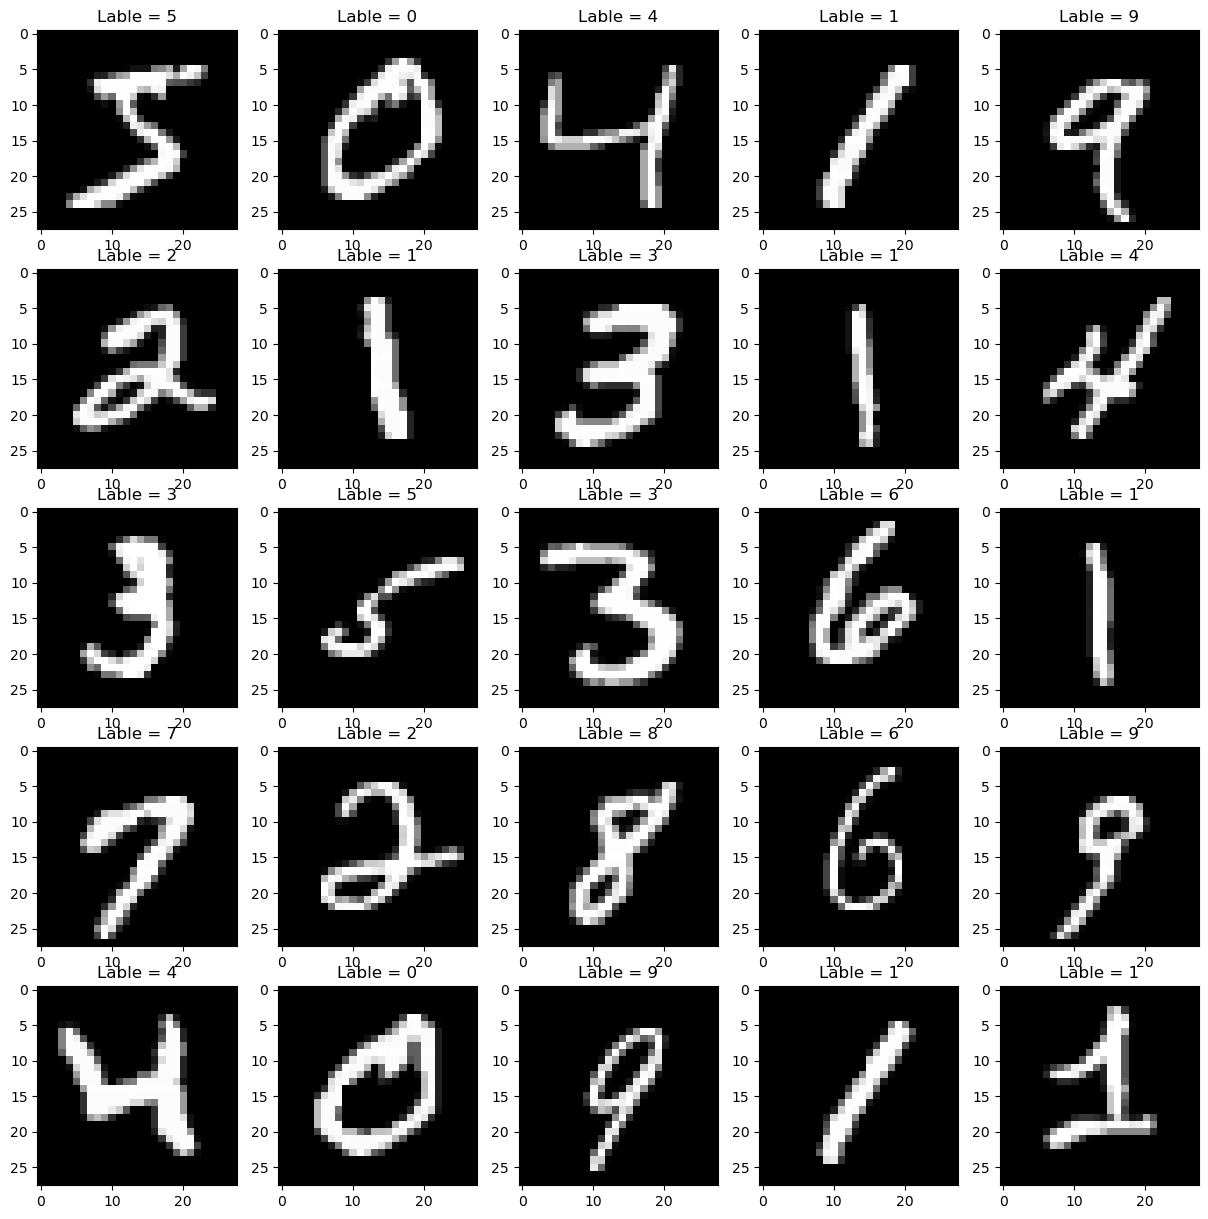

In [165]:
fig, ax = plt.subplots(5, 5, figsize=(15,15))
ax = ax.flatten()

## Your code goes below
for i in range(0, 25):
    _=ax[i].imshow(raw_train_images[i], cmap=plt.get_cmap('gray'))
    _=ax[i].set_title(f'Lable = {train_labels[i]}')



> Examine the images and the labels. What problems can you foresee when a machine learning algorithm attempts to learn to classify the digits shown in these images? Your answer need only be 1 to 3 well chosen sentences.             
> **End of exercise.**

> **Answer:**  
One issue that I see is that the digits have inconsistent orientation/slant. This is most obvious for the ones, which sometimes are perfectly vertical and sometimes have a 45 degree slant. Another potential issue is the inconsistent shapes for the same digits. For instance, the fours sometimes have an open top and sometimes have a closed top. This could be a problem for a classifier model because it may confused the close-toped fours with a nine.  A third issue I see is the pixelation of the images, which will add noise into the labels.  This is less of a concern though, as I think a well-made binary filter could reduce this issue.

In order to perform machine learning with image data you must transform the data to a structure with all the **features** for each image in one row of a **model matrix**. The linear model can then be written:      

$$X b = y$$

where:    
$X$ is the model matrix with the features values for each image in the rows.    
$b$ is the **coefficient vector**, with one coefficient per feature.   
$y$ is the vector of the **labels** which encode the categories of the objects in the images.

The goal is to estimate the vector of **coefficients**, **parameters** or **weights** to **minimize errors** in the the prediction of the label, $y$, given the model matrix, $X$. In machine learning terminology, we say that the model **learns the weights**, $b$, to minimize the errors.     

For this example, we will use the values of the pixels as our feature values. This requires the 2-dimensional images be **flattened** into feature vectors. This concept is illustrated in the figure below.   

<img src="img/FlatteningImge.JPG" alt="Drawing" style="width:600px; height:300px"/>
<center>Flattening an image to a feature vector</center>

> **Exercise 4-2:** You will now flatten the the $28 \times 28$ images to feature vectors. Do the following:    
> 1. Print the shape of the training image array, noticing that each image is a 2-dimensional sub-array.   
> 2. Flatten the images to an array of 60,000 rows using [numpy.reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html). The image arrays are 8 bit integers. Convert them to floating point in the range $[0.0 - 1.0]$, which will normalize the feature values.    
> 3. Print the shape of the flattened image array.   
> 4. Apply the same transformations to the test image array and print the shape of the resulting array.  

In [166]:
## Your code goes below
print(raw_train_images.shape)
train_images = np.reshape(raw_train_images, (60000, 784))
train_images = train_images/255
print(train_images.shape)
type(train_images[0][0])


(60000, 28, 28)
(60000, 784)


numpy.float64

In [167]:
## Your code goes below for the test images
print(raw_test_images.shape)
test_images = np.reshape(raw_test_images, (10000, 784))
test_images = test_images/255
print(test_images.shape)
type(test_images[0][0])



(10000, 28, 28)
(10000, 784)


numpy.float64

> Examine the dimensions of the flattened arrays. How many features will your model have? Your answer should show a simple numeric calculation.    
> **End of exercise.**

> **Answer:**    
Our new model with have 784 features, one feature for each pixel value. For a 28x28 = 784.

It can be instructive to look at the feature matrix. Execute the code in the cell below and examine the results.  

train_images.shape = (60000, 784)


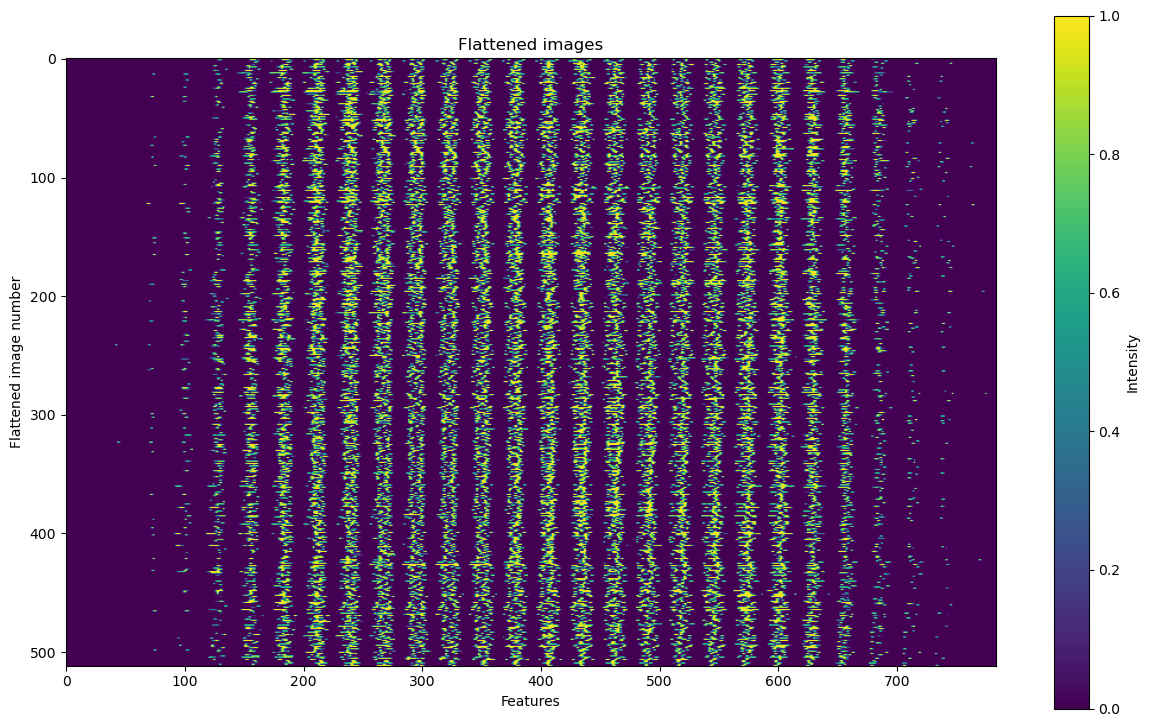

In [168]:
def plot_feature_sample(img, nrows=512):
    fig, ax = plt.subplots(figsize=(15,9))
    p = ax.imshow(img[:nrows,:])
    plt.ylabel('Flattened image number')
    plt.xlabel('Features')
    plt.title('Flattened images')
    cb = plt.colorbar(p)
    _=cb.set_label('Intensity')

print('train_images.shape = ' + str(train_images.shape))
plot_feature_sample(train_images)    

> **Exercise 4-3:** Examine the feature columns in the array displayed above. Notice the differing ranges of values in the features. What does this tell you about the differing information content of the features? In other words, which of these features might you expect to be predictive or not of the digit categories? Your answer need only be 1 to 3 well chosen sentences.           

> **Answer:**      
We can see very distinct bands where the pixels have very different intensity (variance) and then there are big bands where there is zero intensity.  A feature exhibiting zero variance cannot contribute a model, so there are clearly a large number of extraneous features. 

The significant number of uninformative features or pixel locations can lead to problems with model generalization. The coefficients computed for these uninformative features are unlikely to improve model performance. For example, consider that a bit of noise in some images presented to the classifier in production can lead to a high probability of erroneous classifications. 

> **Note:** The behavior of low variance features seen in this example may arise from the way the digit images are cropped. In other cases, it may be better to standardize the variance of the features if all features contain usable information. **In other words, you must expolore and understand the nature of the data before applying any preprocessing step!**        

There are a number of methods we could use to deal with the uninformative features, or pixel locations, in the image data. Transformation such as principle component analysis (PCA) can be effective in such situations. Here, we will take a more direct approach and filter features with close to zero variance. The code in the cell below does this by the following steps:  
1. A feature variance filter is trained using [sklearn-feature-selection-variancethreshold](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html#sklearn-feature-selection-variancethreshold). Notice that we fit on the training data alone, not the test data, to prevent information leakage. 
2. The transformation is applied independently to the training images and test images.  
3. A plot of the first 512 rows of the filtered training data is created and the resulting shape is printed. 

Intial dimension of model matrix = (60000, 784)
Final dimension of model matrix = (60000, 328)


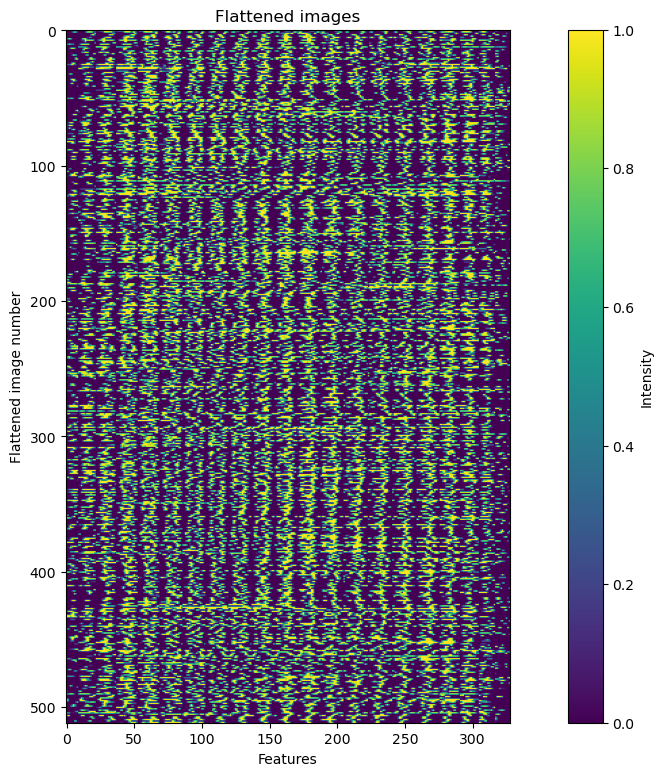

In [169]:
print('Intial dimension of model matrix = ' + str(train_images.shape))
var_threshold = VarianceThreshold(0.05).fit(train_images)
train_images = var_threshold.transform(train_images)
test_images = var_threshold.transform(test_images)


plot_feature_sample(train_images)   
print('Final dimension of model matrix = ' + str(train_images.shape))

> **Exercise 4-4:** Compare the dimensionality and the information content of the filtered features to the original feature set. Does it appear that the information density of the remaining features is high compared to the original? Your answer need only be 1 to 3 well chosen sentences.              

> **Answer:**     
The new feautre-list has about 60% the number of features compared to the original, unfiltered feature vector. The large bands of zero/low variance have been removed leaving only information-dense (or at least high varaince) features as compared to the original feature vector.

## A Linear Model        

With the feature arrays prepared, it is time to construct the machine learning model. The code in the cell below defines the linear **logistic regression** model object and fits it to the training data. Here we use the Scikit-Learn [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) function. The model definition has several key aspects:   
- L2 regularization with a hyperparameter $C = 10.0$.  
- Since there are 10 categories of digits, the multinomial probability distribution is used.    
- An efficient solver for the system of linear equations is selected.    

The `fit` method with the arguments of the model (feature) matrix and the label vector.  

If you are just learning to use Scikit-Learn it is useful to know that the general approach is used for all machine learning models available in the package. A model object is defined including the values of hyperparameters. A fit method is used to compute model parameters or weights using the model matrix and labels as the arguments. The model matrix has the features in the columns, and the cases, in this case flattened images, in the rows. You can find a [Getting Started Guide](https://scikit-learn.org/stable/getting_started.html) in the Scikit-Learn documentation.   

The code in the row below constructs the model object and fits a model. You can see that some `l2` regularization is applied with an hyperparameter of 0.1. Since this is a mutli-class classification problem, the `multi_class='multinomial'` argument is used. Now, execute the code in the cell below to create a model object.  

> **Note:** Depending on your environment, you may need to change the solver to achieve convergence of the linear model. If you encounter this problem, uncomment the line of code below, and comment out the other line. 

In [170]:
C=0.1
LinearClassifier = sklm.LogisticRegression(penalty='l2', C=C, multi_class='multinomial', solver ='newton-cg').fit(train_images, train_labels)

> **Exercise 4-5:** The logistic regression model computes probabilities each of the categories for each case. You will now investigate an example by the following steps:    
> 1. Apply the `predict_proba` method with the test images to the trained classifier method. 
> 2. Display the first 10 rows of the resulting array of probabilities.    
> 3. Sum the probabilities in the array across the classes.  

In [171]:
## Your code goes below

prediction = LinearClassifier.predict_proba(test_images)
pd.DataFrame(prediction).head(10)


,0,1,2,3,4,5,6,7,8,9
0,1.149730e-05,3.652919e-10,4.735786e-05,3.466598e-03,1.157353e-06,0.000019,1.045679e-09,9.961035e-01,0.000017,3.337349e-04
1,9.389611e-03,1.173445e-05,9.380691e-01,6.011774e-03,3.282030e-10,0.017293,2.229336e-02,2.656575e-13,0.006931,6.550129e-10
2,3.529194e-07,9.741340e-01,1.405288e-02,2.497463e-03,1.010067e-04,0.002102,1.260917e-03,2.931493e-03,0.002600,3.200878e-04
3,9.993355e-01,1.320205e-11,1.579607e-04,1.232677e-05,2.059669e-08,0.000300,1.512091e-04,1.073036e-05,0.000021,1.143833e-05
4,1.306634e-04,5.222936e-07,4.416567e-03,6.691151e-05,9.601861e-01,0.000392,1.568458e-03,7.727231e-03,0.002105,2.340656e-02
5,3.134655e-08,9.890866e-01,2.648274e-03,1.701393e-03,1.388261e-05,0.000106,2.463525e-05,4.203432e-03,0.001870,3.456185e-04
6,1.226617e-06,1.337626e-07,6.517753e-07,9.888981e-05,9.724077e-01,0.010955,2.251788e-05,1.042450e-03,0.007619,7.851748e-03
7,8.098891e-08,9.988113e-03,2.174711e-04,2.004353e-03,2.845927e-03,0.003080,5.259263e-05,6.928825e-03,0.003790,9.710918e-01
8,3.382091e-04,8.116678e-08,1.728012e-03,3.749368e-08,4.388167e-04,0.000241,9.970679e-01,3.896548e-09,0.000177,9.138648e-06
9,6.302299e-06,5.613921e-10,4.624725e-07,1.606817e-06,3.765435e-02,0.000058,5.623391e-07,3.908876e-02,0.013102,9.100875e-01


In [172]:
## Your code goes below to sum probabilities
print(np.sum(prediction, axis=1))
np.unique(np.sum(prediction, axis=1)[0])

[1. 1. 1. ... 1. 1. 1.]


array([1.])

> Answer the following questions in 1 to 3 well chosen sentences:  
> 1. Examine the probabilities of the categories for each of the 10 cases. Is there generally a category with the highest probability? Are there cases where another cases has a reasonably high probability?   
> 2. Given your answers to the foregoing question, do you expect this classifier to make errors in identifying the categories?   
> 3. Are these proper probability distributions, in the sense that they sum to 1.0 for each case?  
> **End of exercise.**

> **Answers:**   
> 1. From the first 10 cases, it looks like there is typically one digit which has a high probability and then another that is 1 order of magnitude lower. I cannot see any cases where there are two digits with approximately similar likelihoods. 
> 2. Despite the fact that the model will be cetain about a given digit, I still anticipate that it will make errors. The very first image is misclassified, for instance. 
> 3.  Yes, the only value observed in the row-summation is 1.0.

While it is useful to understand how the linear model algorithm computes probabilities for the categories of digits, for most applications we really only want to know the most probable category. The algorithm is quite simple; pick the category with the highest probability. Scikit-Learn provides the `predict` method that computes the probabilities are returns the category with the highest probability. Execute the code in the cell below to see an example.   

In [173]:
class_predictions = LinearClassifier.predict(test_images)
class_predictions[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 6, 9], dtype=uint8)

## Evaluate the Model       

Now that you have a model and made predictions it is time to evaluate the model. The [Scikit-Learn metrics package](https://scikit-learn.org/stable/modules/model_evaluation.html) contains numerous functions for evaluating different types machine learning models. 

A widely used metric for evaluating classifiers; the number of correctly classified cases divided by all cases:   

$$Accuracy = \frac{TP}{TP + FP + TN + FN}$$    

Where, $TP$ are the true positives, $FP$ are the false positives, and $FN$ are the false negatives. In the **multi-class** case, we count all elements on the diagonal of the confusion matrix as true positive (TP). All cases on the diagonal are corrected classified in one category or another. Thus for computing average accuracy for the multi-class case there are only true positive cases in the numerator of the formula. You can find more details in [this review paper](https://arxiv.org/abs/2008.05756).    

In this case we will focus on evaluation of the multi-class classifier. The [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) computes the accuracy given the actual labels and the predicted values. Execute the code in the cell below and examine the result.         

In [174]:
print(metrics.accuracy_score(test_labels, class_predictions))

0.9182


The overall accuracy of the model seems reasonably good. However, one must be extremely careful when evaluating any machine learning model. Any single metric can be quite misleading. It is good practice to look at several views of model performance.   

The **confusion matrix** can be a powerful tool for evaluating classifiers. The confusion matrix is a 2-dimensional array with the label values on vertical axis and the predicted values on the horizontal axis. The count of correctly classified cases for each category are along the diagonal. Counts or incorrectly classified cases are found off the diagonal. 

The confusion matrix can be computed and displayed numerically. For large numbers of categories a visualization of the confusion matrix can be useful. By studying the confusion matrix one can identify many problems which would not be apparent from one to two simple metrics. For example, accuracy of a classifier might seem quite high, but it could be misclassifying all members of some category, while doing well with other categories. Only by examination of the confusion matrix can such problems be discovered.     

The code in the cell does the following:  
1. Computes the multi-class confusion matrix using the [sklearn.metrics.multilabel_confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html?highlight=multilabel_confusion_matrix) function. 
2. displays the confusion matrix as a Pandas data frame to improve formatting.   
2. Displays the log values of the confusion matrix as an image or heat map. The logarithm is used in this case since the off-diagonal terms are quite small compared to the diagonal terms. A 1 is added to all terms to allow computation of the logarithm, adding a small but negligible bias.     

Execute the code and examine the results. 

     0     1    2    3    4    5    6    7    8    9
0  951     0    3    1    1   10    8    2    3    1
1    0  1112    1    3    0    2    4    2   11    0
2    5     8  921   14    9    7   14   13   33    8
3    4     0   19  909    0   31    4   12   20   11
4    1     2    5    1  910    0   12    5    9   37
5   10     2    8   41    7  770   16    4   27    7
6   10     3    5    1   10   14  912    1    2    0
7    2     9   23    7    9    1    0  946    2   29
8    7    12    4   26    9   34   14    9  849   10
9   10     8    2    7   37    7    0   26   10  902


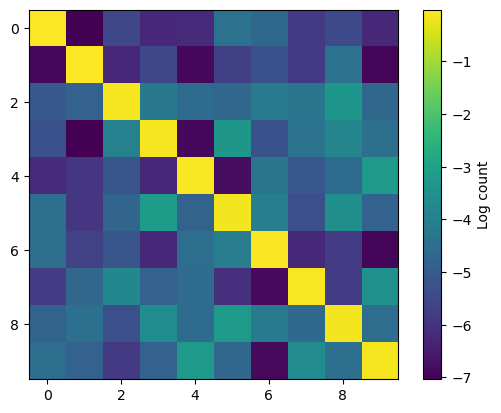

In [175]:
confusion_matrix = metrics.confusion_matrix(test_labels, class_predictions)   
print(pd.DataFrame(confusion_matrix))
p = plt.imshow(np.log(np.divide(confusion_matrix + 1.0, np.sum(confusion_matrix, axis=1))))
cb = plt.colorbar(p)
_=cb.set_label('Log count')

Some other commonly used [performance metrics for classifiers](https://en.wikipedia.org/wiki/Precision_and_recall) are **Precision** and **Recall**. For binary classifiers these metrics are defined:   

\begin{align}
Recall &= \frac{TP}{TP + FN}\\
Precision &=  \frac{TP}{TP + FP}
\end{align} 

You can think of recall as the fraction of positive cases correctly classified, also know as the **sensitivity** of the classifier. The precision or **positive predictive value** is the probability that a positive case can be correctly classified.  

The above formulas cannot be directly applied to the multi-class classification case one typically encounters in CV applications. For this situation we compute class-specific precision and recall from the multi-class confusion matrix using [sklearn.metrics.precision_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score) and [sklearn.metrics.recall_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score). 

The [class specific precision and recall are calculated from the confusion matrix](https://medium.com/data-science-in-your-pocket/calculating-precision-recall-for-multi-class-classification-9055931ee229#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6ImEyOWFiYzE5YmUyN2ZiNDE1MWFhNDMxZTk0ZmEzNjgwYWU0NThkYTUiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJuYmYiOjE2NzM0ODI2NzQsImF1ZCI6IjIxNjI5NjAzNTgzNC1rMWs2cWUwNjBzMnRwMmEyamFtNGxqZGNtczAwc3R0Zy5hcHBzLmdvb2dsZXVzZXJjb250ZW50LmNvbSIsInN1YiI6IjEwMjAwNzU5NTcyMzgwNjA4Nzk4OSIsImVtYWlsIjoic3RlcGhlbi5lbHN0b25AZ21haWwuY29tIiwiZW1haWxfdmVyaWZpZWQiOnRydWUsImF6cCI6IjIxNjI5NjAzNTgzNC1rMWs2cWUwNjBzMnRwMmEyamFtNGxqZGNtczAwc3R0Zy5hcHBzLmdvb2dsZXVzZXJjb250ZW50LmNvbSIsIm5hbWUiOiJTdGVwaGVuIEVsc3RvbiIsInBpY3R1cmUiOiJodHRwczovL2xoMy5nb29nbGV1c2VyY29udGVudC5jb20vYS9BRWRGVHA0YnJDbXJFVFpldW9LeGhqWS01WEFVR2hqU3gxRDdQWmpJVE9RaD1zOTYtYyIsImdpdmVuX25hbWUiOiJTdGVwaGVuIiwiZmFtaWx5X25hbWUiOiJFbHN0b24iLCJpYXQiOjE2NzM0ODI5NzQsImV4cCI6MTY3MzQ4NjU3NCwianRpIjoiMzc1ZjNiMTdmMDA4Mjg4NWQ4ZjgyODlhMzNlYmIyMTVkMjg0NmZjNCJ9.RpejRCenuDVzVPk5hAweRUqR4Pc-pJFRigIIW27mHf7Q0HqiO9CvkLJBu5vSvBoERBw2mdnaHpzpBNtJK3lRT8oPn-KgqX-Utol6lSrWLVGuuefsx4cHdz5CR0q6BOvy4CXk4dgeTpca6Psl51UNeuaV73hs-8bvROXzPoJACRxI0ykCNsf5nzcVysSiv5GOjckj0IfovXeh58N0nj5w4msaRvLUvThGDR7Id35M9JZmfKZimYwFSCC7dNn2Feq6KmkfdxU1U77jGRk9ZZfYSJk0kqIAWTOIh4O2flAwjzpX6ywwgLsBoIrIf1CxAG1d5F79zCapLfDCyOTB4JOVKQ), $C$. These metrics are weighted averages over the correctly and incorrectly classified cases for each label category.       
- The **class specific precision** for the $i$th class is the number of cases correctly classified divided by the sum of the $i$th row:         
$$precision_i = \frac{C_{i,i}}{\sum_j C_{i,j}} = \frac{TP_i}{\sum_j C_{i,j}}$$
- The **class specific recall** for the $j$th class is the number of cases correctly classified divided by the sum of the $j$th column:         
$$recall_j = \frac{C_{j,j}}{\sum_i C_{i,j}} = \frac{TP_j}{\sum_i C_{i,j}}$$

The code in the cell below computes and displays the class specific precision and recall for the classifier just constructed. Execute this code and examine the results.  

In [176]:
unique_labels, label_counts = np.unique(test_labels, return_counts=True)
class_precision = metrics.precision_score(test_labels, class_predictions, labels=unique_labels, average=None)
class_recall = metrics.recall_score(test_labels, class_predictions, labels=unique_labels, average=None)

pd.DataFrame({'Class-specific precision':class_precision, 'Class-specific recall':class_recall})

,Class-specific precision,Class-specific recall
0,0.951000,0.970408
1,0.961938,0.979736
2,0.929364,0.892442
3,0.900000,0.900000
4,0.917339,0.926680
5,0.878995,0.863229
6,0.926829,0.951983
7,0.927451,0.920233
8,0.878882,0.871663
9,0.897512,0.893954


Given the above class-specific precision and recall values the average values of these metrics can be computed as a weighted sum. The frequency of the test labels $n_i$ need not be the same or balanced. The weight, $w_i = n_i/\sum_j n_j$ is the decimal fraction of the 

\begin{align}   
average\ precision &= \sum_i w_i * precision_i\\ 
average\ recall &= \sum_i w_i * recall_i\\ 
w_i &= \frac{n_i}{\sum_j n_j}
\end{align} 

> **Exercise 4-6:** Now you will compute compute and display the average precision and recall scores for the model by creating and executing code in the cell below. 
> 1. Display the frequency of the unique labels, in the `label_counts` variable computed in the previous cell.   
> 2. Compute and display the weighted average of the precision and recall metrics.    

In [177]:
## Put your code below  
print('Frequency of test labels = ' + str(label_counts))
weighted_average = lambda x: round(len(test_labels) * np.sum(np.divide(x, label_counts)), 2)
print('Average precision = ' + str(weighted_average(class_precision)))
print('Average recall = ' + str(weighted_average(class_recall)))

Frequency of test labels = [ 980 1135 1032 1010  982  892  958 1028  974 1009]
Average precision = 91.91
Average recall = 91.9


> Answer the following questions in 1 to 3 well chosen sentences:  
> 1. Referring to the class-specific precision and recall computed above, what does the variation in the precision and recall scores of the different digit classes tell you about the performance of the classifier?   
> 2. Average precision and recall scores are often used to summarize the performance of multi-class classifiers. In this case, do you think the summary is reasonable, or does it loose too much information? 
> **End of exercise.**

> **Answers:**  
> 1.  I see from the heatmap and the underlying values that the errors are not concentrated in any specific area. There is, to my eye, no general trend. Thus, the classifier is performing relatively consistently.
> 2.  Given that there are no obvious patterns that I can see, I think this summary is reasonable. 

> **Exercise 4-7:** To better understand the source of errors from the classifier model it is useful to examine some details of the erroneously classified cases. You will now do the following:    
> 1. Create an index vector of the erroneously classified cases.     
> 2. Create a Pandas data frame containing the class probabilities for the first 25 misclassified cases encountered. Hint, it will improve the readability of your display if you round to 3 decimal places.    
> 3. Append a column of the corresponding test labels to the data frame.  
> 2. Display the data frame.    
> 3. Create a a $5 \times 5$ grid display the first 25 gray-scale erroneously classified images. Give each image display a title with the label for that image and the predicted class. *Hint,* use a large display area.  

In [178]:
test_images

array([[0.        , 0.        , 0.        , ..., 0.        , 0.99607843,
        0.85882353],
       [0.99215686, 0.99215686, 0.99215686, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.90196078,
        0.14901961],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.0627451 , ..., 0.        , 0.        ,
        0.        ]])

In [179]:
## Your code goes below

incorrect_images = pd.DataFrame({"Labels" : test_labels, "Predict" : class_predictions}).query("Labels != Predict").head(25)
incorrect_images

,Labels,Predict
8,5,6
33,4,6
63,3,2
66,6,2
77,2,7
92,9,4
124,7,4
149,2,9
193,9,3
195,3,5


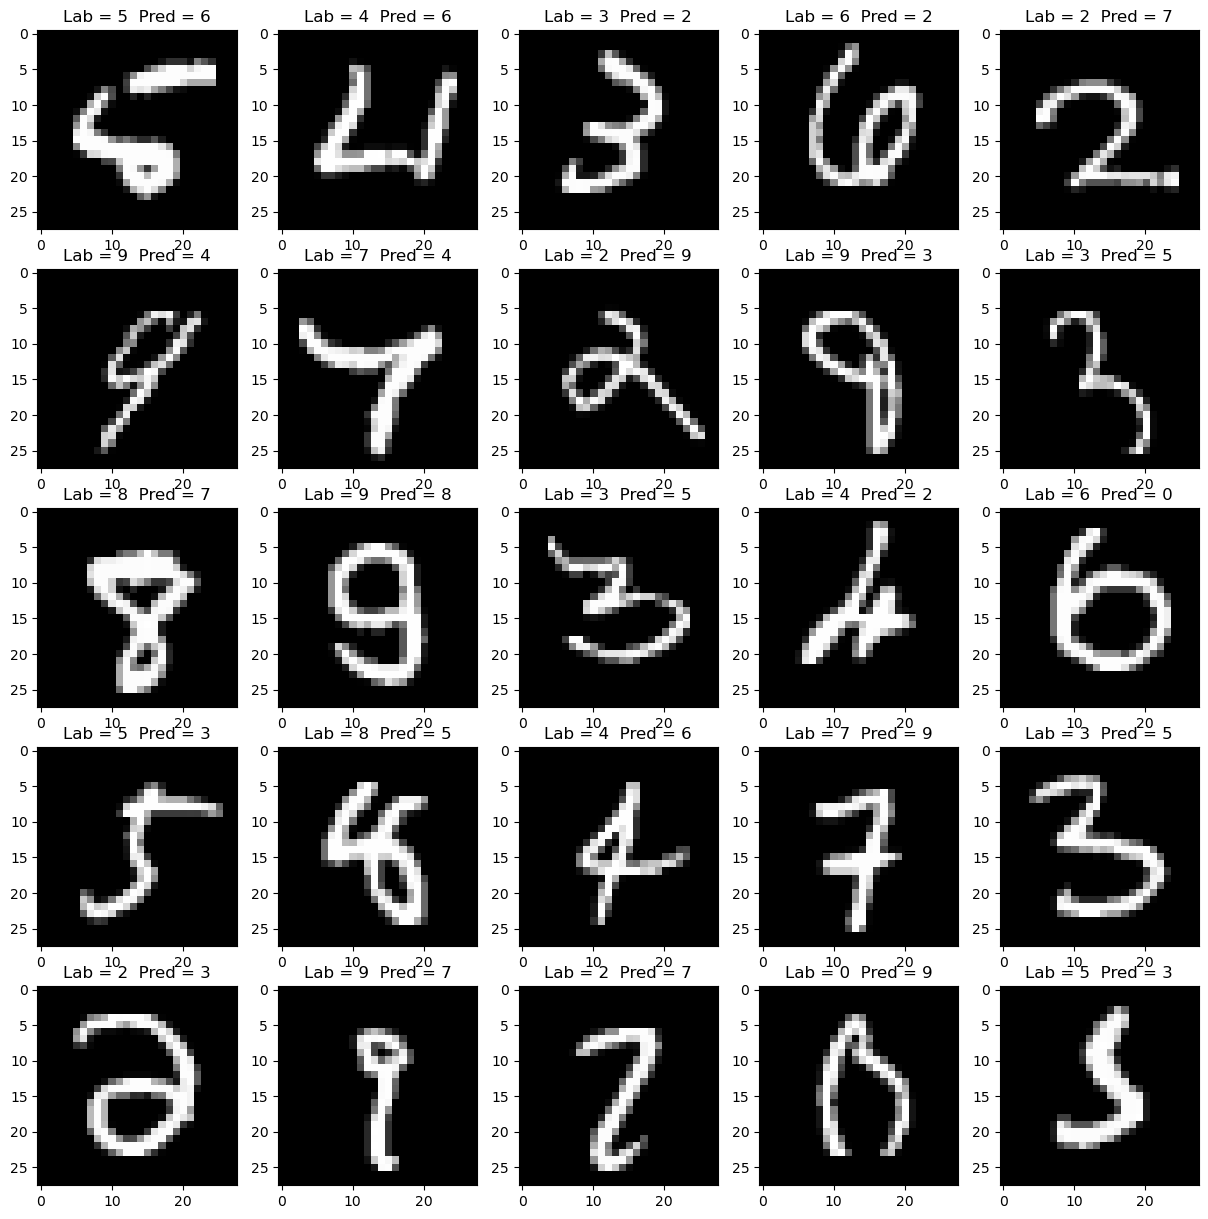

In [180]:
## Your code goes below to display the images with predicted and label values
fig, ax = plt.subplots(5, 5, figsize=(15,15))
ax = ax.flatten()

## Your code goes below
ax_index = 0
for i in incorrect_images.index:
    #print(i)
    _=ax[ax_index].imshow(raw_test_images[i], cmap=plt.get_cmap('gray'))
    _=ax[ax_index].set_title(f'Lab = {incorrect_images.Labels[i]}  Pred = {incorrect_images.Predict[i]}')
    ax_index+=1




In [181]:
pd.DataFrame(LinearClassifier.predict_proba(test_images[incorrect_images.index[0:5]]))

,0,1,2,3,4,5,6,7,8,9
0,0.000338,8.116678e-08,0.001728,3.749368e-08,0.000439,0.000241,0.997068,3.896548e-09,0.000177,0.000009
1,0.255527,4.173679e-09,0.030229,4.294753e-07,0.021610,0.013435,0.678741,2.255616e-06,0.000414,0.000042
2,0.000076,2.382574e-04,0.809351,1.410473e-01,0.000110,0.001118,0.000307,8.370849e-07,0.047053,0.000698
3,0.000308,3.793193e-04,0.317098,1.939117e-01,0.056581,0.009904,0.098328,3.128772e-01,0.007845,0.002767
4,0.000713,8.862761e-03,0.293353,9.312029e-03,0.002317,0.012277,0.006415,5.820799e-01,0.004858,0.079812


> Examine and compare the images of the misclassified digits to the probabilities of class assignment in the printed table. Notice that some of the digits shown are very poorly formed. Find a few such examples and then examine the category probabilities. Given the image and the probabilities describe why you think the error might have occurred.     
> **End of exercise.**     

> **Answer:**        
From looking at the first 5 misclassified images, we can see the model was VERY confident just once (99%) but at the other times it was no more than 80% confident. Thus, I think that by FORCING the model to make a choice when it is uncertain we may be causing bad outcomes.  However, this is only showing the number of times it made an error in these close cases. Further analysis would reveal how many times it is choosing correctly in these uncertain scenarios. 

> **Exercise 4-8:** You may well wonder how the regularization hyperparameter was chosen for the model you have been working with. The answer is a hyperparameter search was performed. Now, do the following:   
> 1. Define a list of hyperparameter candidates, $[0.01,0.03,0.1,0.3,1.0,3.0]$.
> 2. Define 2 empty lists for accumulating accuracy values.    
> 3. Iterate over the hyperparameter values. For each value fit a Logistic Regression model, compute the class predictions using both train and test data, and then append the train and test accuracy of the model to the associated list.   
> 4. Outside the loop compute lists (or arrays) of the train and test error rates for your model as $1.0 - accuracy$.
> 5. Display the test error for each value of C.  
> 6. Execute your code, which may take some time.  

In [182]:
np.random.seed(7890)
## Put your code below

test = []
train = []
hyperparams = [0.01,0.03,0.1,0.3,1.0,3.0]

for C in hyperparams:

    log_model = sklm.LogisticRegression(penalty='l2', C=C, multi_class='multinomial', solver ='newton-cg').fit(train_images, train_labels)

    train_predicitons = log_model.predict(train_images)
    train.append(metrics.accuracy_score(train_labels, train_predicitons))

    test_predictions = log_model.predict(test_images)
    test.append(metrics.accuracy_score(test_labels, test_predictions))

print(train)
print(test)




[0.9105166666666666, 0.9163, 0.9204333333333333, 0.9224666666666667, 0.92355, 0.9239833333333334]
[0.9125, 0.9163, 0.9182, 0.918, 0.9173, 0.9171]


> 6. On a reasonable size plot area, display a graph of the hyperparameter values on the horizontal axis and the train and test errors on the vertical axis. Include a legend on your plot so you can tell which line is the test and which is the train error. *Hint:* Your plot will be easier to interpret if you use a log scale on the horizontal axis using `ax.set_xscale('log')`.  

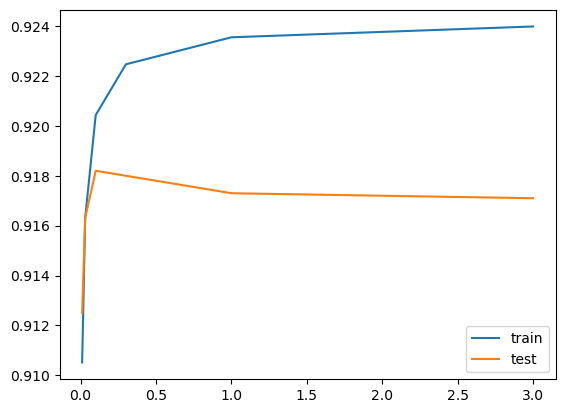

In [185]:
## Put your code below


plt.plot(hyperparams, train, label = "train")
plt.plot(hyperparams, test, label="test")
plt.legend()
plt.show()




> Examine the graph and answer the following questions:
> 1. Given the results, why do you think the hyperparameter used was selected for the model?   
> 2. What does divergence between test and training error with increasing hyperparameter value tell you about improving the generalizeability of the model?   
> **End of exercise.** 

> **Answers:**  
> 1.  The hyperparam of 0.1 is the hyperparam where the test error begins to flatten out, just like looking for the kink in a KMeans Hyperparameter search. Further, this is the point before the test and train accuracy begin to diverge.    
> 2.  Increasing the hyperparameter beyond 0.1 leads to an unacceptable level of bias in the training model and therefore it will not generalize well to other problems.   

#### Copyright  2018, 2019, 2020, 2021, 2022, 2023, Stephen F Elston. All rights reserved.  